# B. Logistic Regression on BreastMNIST

B1 Data loading and inspection

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data. Display at least ten images for each class, i.e. at least 20 images, from the training set. Display at least ten images for each class from the validation set, and display at least ten images for each class from the test set.

In [1]:
# follow instructions to download and load the data
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [2]:
data_flag = 'breastmnist'
download = True
BATCH_SIZE = 128
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset =  DataClass(split='val', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/guoyi/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/guoyi/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/guoyi/.medmnist/breastmnist.npz


In [3]:
# define a function to display images
def showimgs(dataset):
    class1 = list()
    class0 = list()
    for i in range(len(dataset)): # get different classes according to the labels(postive or nagative) of data
        if dataset.labels[i] == 0:
            class1.append(dataset[i]) # store the data to a new class list
        elif dataset.labels[i] == 1:
            class0.append(dataset[i])
# show the pictures of these classes           
    class1_pic = np.array(class1[:][0][0]).reshape(1, 28*28)
    for i in range(1, len(class1[:])):
        class1_pic = np.append(class1_pic,np.array(class1[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
    fig, axes = plt.subplots(1,10,figsize=(8,8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        ax.imshow(class1_pic[i].reshape(28,28),cmap="gray")
    
    class0_pic = np.array(class0[:][0][0]).reshape(1, 28*28)
    for i in range(1, len(class0[:])):
        class0_pic = np.append(class0_pic,np.array(class0[:][i][0].numpy()).reshape(1, 28*28),axis = 0)

    fig, axes = plt.subplots(1,10,figsize=(8,8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        ax.imshow(class0_pic[i].reshape(28,28),cmap="gray")

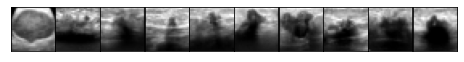

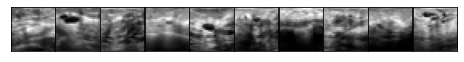

In [4]:
showimgs(train_dataset)

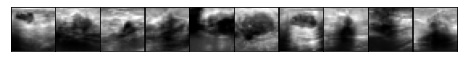

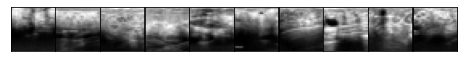

In [5]:
showimgs(val_dataset)

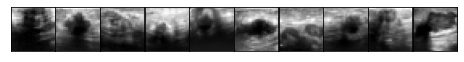

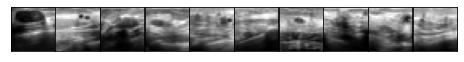

In [6]:
showimgs(test_dataset)

B2 Logistic regression

Keep a record of the three metrics M1 to M3 below for the two models below: <br>
M1) Training accuracy: the prediction accuracy of a trained model on the training dataset.<br>
M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset.<br>
M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.

a) Using the built-in logistic regression functions in scikit-learn, train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3

In [7]:
torch.manual_seed(69752)

In [8]:
# reconstruct the structure of dataset to make it easy to train a logistic regression
x_train = train_dataset.imgs
y_train = train_dataset.labels
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_val = val_dataset.imgs
y_val = val_dataset.labels
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2])

x_test = test_dataset.imgs
y_test = test_dataset.labels
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [9]:
# change the dimention of y_train
y_train = y_train.squeeze(1)

In [10]:
# Using the built-in logistic regression functions in scikit-learn, 
# train a logistic regression model with L2 regularisation on the training set
from sklearn.linear_model import LogisticRegression

np.random.seed(69752)
c = np.linspace(0.00005, 0.001, 5) # create a series of l2 regularisation values
best_c = 0 
index = 0.5
for i in range(len(c)): # find the best l2 regularisation value through for loop and save it in best_c variable
    L2LR = LogisticRegression(solver='sag', penalty= 'l2', C = c[i], max_iter = 3000)  # strat to train the logistic regression model using training dataset
    L2LR.fit(x_train, y_train)
    training_accuracy = L2LR.score(x_val, y_val) # test the chosen model on test dataset
    if(training_accuracy > index):
        index = training_accuracy
        best_c = c[i]
print('the best hyperparameter is:', best_c)

# using the best l2 regularisation value to calculate accuracy in different dataset and report the three matrics
L2LR = LogisticRegression(solver='sag', penalty= 'l2', C = best_c, max_iter = 3000)
L2LR.fit(x_train, y_train)
train_accuracy_skl = L2LR.score(x_train, y_train)
val_accuracy_skl = L2LR.score(x_val, y_val)
test_accuracy_skl = L2LR.score(x_test, y_test)
print('M1:', train_accuracy_skl)
print('M2:', val_accuracy_skl)
print('M3:', test_accuracy_skl)
#three metrics are covered by the next red command so you need to scroll down with the mouse wheel to see it

the best hyperparameter is: 5e-05
M1: 0.9377289377289377
M2: 0.8461538461538461
M3: 0.7948717948717948


B2
b) Using PyTorch (see Question 5 of Lab 6), train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3

In [11]:
# use pytorch to train a logistic regression model
msamples, mx, my = test_dataset.imgs.shape
x_test = test_dataset.imgs.reshape((msamples,mx*my))
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
#logistic regression
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression,self).__init__()
        self.lrnet = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1),
            nn.Sigmoid()
        )
#The forward propagation
    def forward(self, x):
        x = self.lrnet(x)
        return x
#train a logistic regression model with the first l2 regularisation value and report the three metrics M1 to M3
LR_first = LogisticRegression()
criterion=nn.BCELoss() 
optimizer=torch.optim.SGD(LR_first.parameters(),lr=0.03,momentum=0.009, weight_decay = 0.0001) 
y_train = torch.squeeze(y_train).float()
max_epochs = 300
# start to train the logistic regression model
for epoch in range(max_epochs):
    for data in train_loader:
        images, labels = data
        labels = labels.type(torch.float)
        optimizer.zero_grad() # Gradient to zero
        preds = LR_first(images) # use model to calculate predictions
        loss = criterion(preds, labels) # calculate loss
        loss.backward() # Backward propagation
        optimizer.step()  # optimizer

In [12]:
# define a evaluation function to calculate the accuracy of logistic regression model
def evaluation(dataloader, model):
    correct_num, total_num = 0, 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            labels = labels.type(torch.float)
            preds = model(images)
            preds = preds.round()
            correct_num += (preds == labels).sum().item()
            total_num += labels.size(0)
        acc = correct_num / total_num
    return acc
# report M1, M2 and M3
train_acc_1 = evaluation(train_loader, LR_first)
print('M1 of the first logistic regression model:', train_acc_1)
val_acc_1 = evaluation(val_loader, LR_first)
print('M2 of the first logistic regression model:', val_acc_1)
test_acc_1 = evaluation(test_loader, LR_first)
print('M3 of the first logistic regression model:', test_acc_1)

M1 of the first logistic regression model: 0.8534798534798534
M2 of the first logistic regression model: 0.8589743589743589
M3 of the first logistic regression model: 0.8141025641025641


In [13]:
#train a logistic regression model with the second l2 regularisation value and report the three metrics M1 to M3
LR_second = LogisticRegression()
criterion=nn.BCELoss() 
optimizer=torch.optim.SGD(LR_second.parameters(),lr=0.03,momentum=0.009, weight_decay = 0.0003) 
y_train = torch.squeeze(y_train).float()
max_epochs = 300
# use a new L2 regularisation value to train the logistic regression model
for epoch in range(max_epochs):
    for data in train_loader:
        images, labels = data
        labels = labels.type(torch.float)
        optimizer.zero_grad() # Gradient to zero
        preds = LR_second(images) # use model to calculate predictions
        loss = criterion(preds, labels) # calculate loss
        loss.backward() # Backward propagation
        optimizer.step() # optimizer
# report M1, M2 and M3
train_acc_2 = evaluation(train_loader, LR_second)
print('M1 of the second logistic regression model:', train_acc_2)
val_acc_2 = evaluation(val_loader, LR_second)
print('M2 of the second logistic regression model:', val_acc_2)
test_acc_2 = evaluation(test_loader, LR_second)
print('M3 of the second logistic regression model:', test_acc_2)

M1 of the second logistic regression model: 0.8333333333333334
M2 of the second logistic regression model: 0.8589743589743589
M3 of the second logistic regression model: 0.8141025641025641


In [14]:
#train a logistic regression model with the third l2 regularisation value and report the three metrics M1 to M3
LR_third = LogisticRegression()
criterion=nn.BCELoss() 
optimizer=torch.optim.SGD(LR_third.parameters(),lr=0.03,momentum=0.009, weight_decay = 0.0005) 
y_train = torch.squeeze(y_train).float()
max_epochs = 300
# use a new L2 regularisation value to train the logistic regression model
for epoch in range(max_epochs):
    for data in train_loader:
        images, labels = data
        labels = labels.type(torch.float)
        optimizer.zero_grad() # Gradient to zero
        preds = LR_second(images) # use model to calculate predictions
        loss = criterion(preds, labels) # calculate loss
        loss.backward() # Backward propagation
        optimizer.step() # optimizer
# report M1, M2 and M3
train_acc_3 = evaluation(train_loader, LR_third)
print('M1 of the third logistic regression model:', train_acc_3)
val_acc_3 = evaluation(val_loader, LR_third)
print('M2 of the third logistic regression model:', val_acc_3)
test_acc_3 = evaluation(test_loader, LR_third)
print('M3 of the third logistic regression model:', test_acc_3)

M1 of the third logistic regression model: 0.7032967032967034
M2 of the third logistic regression model: 0.7051282051282052
M3 of the third logistic regression model: 0.7051282051282052


B3 Performance comparison

a) Summarise each of the three metrics from the two chosen models in B2 using one or more bar graphs.

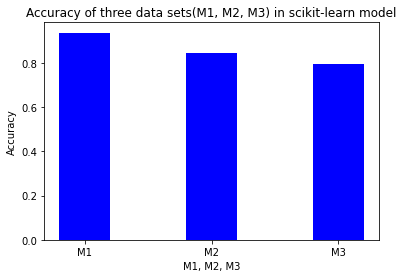

In [15]:
X=['M1', 'M2', 'M3']
Y=[train_accuracy_skl, val_accuracy_skl, test_accuracy_skl]  
fig = plt.figure()
plt.bar(X,Y,0.4,color="blue")
plt.xlabel("M1, M2, M3")
plt.ylabel("Accuracy")
plt.title("Accuracy of three data sets(M1, M2, M3) in scikit-learn model")
plt.show()

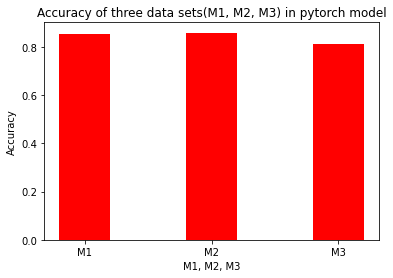

In [16]:
X=['M1', 'M2', 'M3']
Y=[train_acc_1, val_acc_1, test_acc_1]  
fig = plt.figure()
plt.bar(X,Y,0.4,color="red")
plt.xlabel("M1, M2, M3")
plt.ylabel("Accuracy")
plt.title("Accuracy of three data sets(M1, M2, M3) in pytorch model")
plt.show()

b) Describe at least two observations interesting to you. 

1) The data set used for this assignment is different from the previous CSV data set, which cause some problems at the begining because I didnot know how to get the data set labels and coordinates. But when I read the original author's code carefully, I find that there are .imgs and .labels I could use directly so this problem became bit simple.<br>
2) In the lab class, we just learn how to handle two-dimensional data set but this data set is three-dimensional, which made me confused. but when I looked it up on the Internet, I find a sensible way to make it become two-dimensional. The code is like this: x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2]). Based on this, I successfully completed the follow-up tasks.

# C. Convolutional Neural Networks on OCTMNIST

C1 Data loading and inspection

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data. Display at least ten images for each class, i.e. at least 40 images, from the training set. 

In [17]:
import time
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [18]:
# follow instructions to download and load the data
data_flag = 'octmnist'
download = True
num_epochs = 3
BATCH_SIZE = 128
lr = 0.001
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset =  DataClass(split='val', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /Users/guoyi/.medmnist/octmnist.npz
Using downloaded and verified file: /Users/guoyi/.medmnist/octmnist.npz
Using downloaded and verified file: /Users/guoyi/.medmnist/octmnist.npz


In [19]:
# define a function to show images for each class
def displayimgs(dataset):
    class1 = list()
    class0 = list()
    for i in range(1000): # get different classes according to the labels(postive or nagative) of data
        if dataset.labels[i] == 0:
            class1.append(dataset[i]) # store the data to a new class list
        elif dataset.labels[i] == 1:
            class0.append(dataset[i])
# show the pictures of these classes           
    class1_pic = np.array(class1[:][0][0]).reshape(1, 28*28)
    for i in range(1, len(class1[:])):
        class1_pic = np.append(class1_pic,np.array(class1[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
    fig, axes = plt.subplots(1,10,figsize=(8,8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        ax.imshow(class1_pic[i].reshape(28,28),cmap="gray")
    
    class0_pic = np.array(class0[:][0][0]).reshape(1, 28*28)
    for i in range(1, len(class0[:])):
        class0_pic = np.append(class0_pic,np.array(class0[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
    fig, axes = plt.subplots(1,10,figsize=(8,8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        ax.imshow(class0_pic[i].reshape(28,28),cmap="gray")

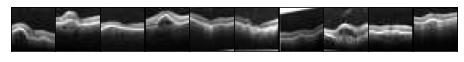

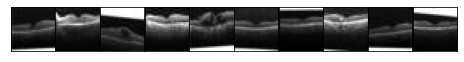

In [20]:
# display images for each class from training set
displayimgs(train_dataset)

C2 Convolutional neural networks

Keep a record of the four metrics M1 to M4 below for the two models below:<br>
M1) Training accuracy: the prediction accuracy of a trained model on the training dataset.<br>
M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset.<br>
M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.<br>
M4) Training time: the time taken to train the model (i.e. to learn/estimate the learnable parameters) on the training dataset.

a) Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4

In [21]:
# Design a CNN with two Conv layers and two FC layers.
# the first choice of CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # two conv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                 in_channels = 1,
                 out_channels = 16,
                 kernel_size = 5,
                 stride = 1,
                 padding = 2,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        # two fc layers
        self.out = nn.Linear(32*7*7, 4)
        nn.Sigmoid()
        self.out = nn.Linear(32*7*7, 4)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [22]:
# define a function to calculate accuracy
def accuracy(predictions, labels):
    pred =  torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [23]:
#start to train the the first CNN model and report M1 to M4
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
time_start = time.time()
two_layers_M1_1 = 0
two_layers_M2_1 = 0
two_layers_M3_1 = 0
two_layers_M4_1 = 0
for epoch in range(num_epochs):
    train_right = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = criterion(output, target.squeeze(1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_right.append(right)
        
        if batch_idx % 100 ==0:
            net.eval()
            val_right = []
            for(data, target) in val_loader:
                output = net(data)
                right = accuracy(output, target)
                val_right.append(right)
                
        if batch_idx % 100 ==0:
            net.eval()
            test_right = []
            for(data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                test_right.append(right)
            
            train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
            val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
            test_r = ((sum([tup[0] for tup in test_right]), sum([tup[1] for tup in test_right])))
            time_end = time.time()
            
            two_layers_M1_1 = 100. *train_r[0].numpy() / train_r[1],
            two_layers_M2_1 = 100. *val_r[0].numpy()/ val_r[1],
            two_layers_M3_1 = 100. *test_r[0].numpy()/ test_r[1],
            two_layers_M4_1 = 1. * time_end - time_start
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t M1:{:.2f}%\t M2:{:.2f}%\t M3:{:.2f}%\t M4:{:.3f}s\t'.format(
                  epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset),
                  100. *batch_idx / len(train_loader),
                  loss.data,
                  100. *train_r[0].numpy() / train_r[1],
                  100. *val_r[0].numpy()/ val_r[1],
                  100. *test_r[0].numpy()/ test_r[1],
                  1. * time_end - time_start))

epoch: 0 [0/97477 (0%)]	loss: 1.457317	 M1:20.31%	 M2:48.05%	 M3:25.00%	 M4:2.908s	
epoch: 0 [12800/97477 (13%)]	loss: 0.655403	 M1:67.93%	 M2:75.56%	 M3:57.30%	 M4:14.868s	
epoch: 0 [25600/97477 (26%)]	loss: 0.609280	 M1:72.98%	 M2:71.52%	 M3:61.20%	 M4:26.818s	
epoch: 0 [38400/97477 (39%)]	loss: 0.511255	 M1:75.30%	 M2:77.83%	 M3:62.70%	 M4:38.785s	
epoch: 0 [51200/97477 (52%)]	loss: 0.552181	 M1:76.76%	 M2:73.69%	 M3:59.90%	 M4:50.813s	
epoch: 0 [64000/97477 (66%)]	loss: 0.536962	 M1:77.79%	 M2:78.27%	 M3:61.30%	 M4:62.780s	
epoch: 0 [76800/97477 (79%)]	loss: 0.477690	 M1:78.54%	 M2:81.52%	 M3:64.90%	 M4:74.740s	
epoch: 0 [89600/97477 (92%)]	loss: 0.509361	 M1:79.23%	 M2:81.24%	 M3:66.60%	 M4:86.689s	
epoch: 1 [0/97477 (0%)]	loss: 0.467419	 M1:85.94%	 M2:83.48%	 M3:67.00%	 M4:95.113s	
epoch: 1 [12800/97477 (13%)]	loss: 0.421405	 M1:84.80%	 M2:82.98%	 M3:65.10%	 M4:107.616s	
epoch: 1 [25600/97477 (26%)]	loss: 0.606749	 M1:84.80%	 M2:84.19%	 M3:67.40%	 M4:119.646s	
epoch: 1 [38400/974

In [24]:
# the second choice of CNN
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                 in_channels = 1,
                 out_channels = 8,
                 kernel_size = 5,
                 stride = 1,
                 padding = 2,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(16*7*7, 4)
        nn.Sigmoid()
        self.out = nn.Linear(16*7*7, 4)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [25]:
#start to train the the second CNN model and report M1 to M4
net = CNN2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
time_start = time.time()
two_layers_M1_2 = 0
two_layers_M2_2 = 0
two_layers_M3_2 = 0
two_layers_M4_2 = 0
for epoch in range(num_epochs):
    train_right = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = criterion(output, target.squeeze(1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_right.append(right)
        
        if batch_idx % 100 ==0:
            net.eval()
            val_right = []
            for(data, target) in val_loader:
                output = net(data)
                right = accuracy(output, target)
                val_right.append(right)
                
        if batch_idx % 100 ==0:
            net.eval()
            test_right = []
            for(data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                test_right.append(right)
            
            train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
            val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
            test_r = ((sum([tup[0] for tup in test_right]), sum([tup[1] for tup in test_right])))
            time_end = time.time()
            two_layers_M1_2 = 100. *train_r[0].numpy() / train_r[1],
            two_layers_M2_2 = 100. *val_r[0].numpy()/ val_r[1],
            two_layers_M3_2 = 100. *test_r[0].numpy()/ test_r[1],
            two_layers_M4_2 = 1. * time_end - time_start
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t M1:{:.2f}%\t M2:{:.2f}%\t M3:{:.2f}%\t M4:{:.3f}s\t'.format(
                  epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset),
                  100. *batch_idx / len(train_loader),
                  loss.data,
                  100. *train_r[0].numpy() / train_r[1],
                  100. *val_r[0].numpy()/ val_r[1],
                  100. *test_r[0].numpy()/ test_r[1],
                  1. * time_end - time_start))

epoch: 0 [0/97477 (0%)]	loss: 1.352277	 M1:30.47%	 M2:46.94%	 M3:31.30%	 M4:1.714s	
epoch: 0 [12800/97477 (13%)]	loss: 0.603470	 M1:68.16%	 M2:74.58%	 M3:49.60%	 M4:7.622s	
epoch: 0 [25600/97477 (26%)]	loss: 0.711271	 M1:72.89%	 M2:78.57%	 M3:62.50%	 M4:13.576s	
epoch: 0 [38400/97477 (39%)]	loss: 0.486780	 M1:75.40%	 M2:79.75%	 M3:64.70%	 M4:19.691s	
epoch: 0 [51200/97477 (52%)]	loss: 0.558274	 M1:76.90%	 M2:81.94%	 M3:62.60%	 M4:25.884s	
epoch: 0 [64000/97477 (66%)]	loss: 0.582473	 M1:77.84%	 M2:75.47%	 M3:61.40%	 M4:31.781s	
epoch: 0 [76800/97477 (79%)]	loss: 0.430471	 M1:78.64%	 M2:82.86%	 M3:64.70%	 M4:37.681s	
epoch: 0 [89600/97477 (92%)]	loss: 0.532717	 M1:79.24%	 M2:83.51%	 M3:66.20%	 M4:43.583s	
epoch: 1 [0/97477 (0%)]	loss: 0.388380	 M1:85.16%	 M2:83.18%	 M3:66.10%	 M4:47.857s	
epoch: 1 [12800/97477 (13%)]	loss: 0.520219	 M1:83.74%	 M2:83.35%	 M3:60.80%	 M4:53.757s	
epoch: 1 [25600/97477 (26%)]	loss: 0.544589	 M1:84.22%	 M2:83.23%	 M3:64.80%	 M4:59.654s	
epoch: 1 [38400/97477 

In [26]:
# the third choice of CNN
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Sequential( # the first conv layer
            nn.Conv2d(
                 in_channels = 1,
                 out_channels = 16,
                 kernel_size = 3,
                 stride = 2,
                 padding = 2,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential( # the second conv layer
            nn.Conv2d(16,32,3,2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(128, 128)
        nn.Sigmoid()
        self.out = nn.Linear(128, 128)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [27]:
#start to train the the third CNN model and report M1 to M4
net = CNN3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
time_start = time.time()
two_layers_M1_3 = 0
two_layers_M2_3 = 0
two_layers_M3_3 = 0
two_layers_M4_3 = 0
for epoch in range(num_epochs):
    train_right = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = criterion(output, target.squeeze(1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_right.append(right)
        
        if batch_idx % 100 ==0:
            net.eval()
            val_right = []
            for(data, target) in val_loader:
                output = net(data)
                right = accuracy(output, target)
                val_right.append(right)
                
        if batch_idx % 100 ==0:
            net.eval()
            test_right = []
            for(data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                test_right.append(right)
            
            train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
            val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
            test_r = ((sum([tup[0] for tup in test_right]), sum([tup[1] for tup in test_right])))
            time_end = time.time()
            two_layers_M1_3 = 100. *train_r[0].numpy() / train_r[1],
            two_layers_M2_3 = 100. *val_r[0].numpy()/ val_r[1],
            two_layers_M3_3 = 100. *test_r[0].numpy()/ test_r[1],
            two_layers_M4_3 = 1. * time_end - time_start
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t M1:{:.2f}%\t M2:{:.2f}%\t M3:{:.2f}%\t M4:{:.3f}s\t'.format(
                  epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset),
                  100. *batch_idx / len(train_loader),
                  loss.data,
                  100. *train_r[0].numpy() / train_r[1],
                  100. *val_r[0].numpy()/ val_r[1],
                  100. *test_r[0].numpy()/ test_r[1],
                  1. * time_end - time_start))

epoch: 0 [0/97477 (0%)]	loss: 5.273500	 M1:0.00%	 M2:0.00%	 M3:0.00%	 M4:1.047s	
epoch: 0 [12800/97477 (13%)]	loss: 0.897296	 M1:55.82%	 M2:66.98%	 M3:41.20%	 M4:3.908s	
epoch: 0 [25600/97477 (26%)]	loss: 0.724557	 M1:63.50%	 M2:68.98%	 M3:47.50%	 M4:6.770s	
epoch: 0 [38400/97477 (39%)]	loss: 0.840250	 M1:66.83%	 M2:75.05%	 M3:51.80%	 M4:9.629s	
epoch: 0 [51200/97477 (52%)]	loss: 0.856865	 M1:69.01%	 M2:76.45%	 M3:54.00%	 M4:12.488s	
epoch: 0 [64000/97477 (66%)]	loss: 0.706641	 M1:70.57%	 M2:77.47%	 M3:53.80%	 M4:15.345s	
epoch: 0 [76800/97477 (79%)]	loss: 0.571594	 M1:71.78%	 M2:73.39%	 M3:52.30%	 M4:18.637s	
epoch: 0 [89600/97477 (92%)]	loss: 0.615380	 M1:72.69%	 M2:78.06%	 M3:52.50%	 M4:21.917s	
epoch: 1 [0/97477 (0%)]	loss: 0.619280	 M1:78.12%	 M2:79.02%	 M3:54.80%	 M4:24.253s	
epoch: 1 [12800/97477 (13%)]	loss: 0.608324	 M1:79.41%	 M2:76.75%	 M3:57.50%	 M4:27.495s	
epoch: 1 [25600/97477 (26%)]	loss: 0.541039	 M1:79.54%	 M2:75.96%	 M3:53.70%	 M4:30.363s	
epoch: 1 [38400/97477 (39%)

b) Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 

In [28]:
#design the first CNN with 3 conv layers and 3 fc layers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # three conv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                 in_channels = 1,
                 out_channels = 16,
                 kernel_size = 5,
                 stride = 1,
                 padding = 2,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        # three fc layers
        self.out = nn.Linear(576, 128)
        nn.Sigmoid()
        self.out = nn.Linear(576, 128)
        nn.Sigmoid()
        self.out = nn.Linear(576, 128)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [29]:
def accuracy(predictions, labels):
    pred =  torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [30]:
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
time_start = time.time()
three_layers_M1_1 = 0
three_layers_M2_1 = 0
three_layers_M3_1 = 0
three_layers_M4_1 = 0
for epoch  in range(num_epochs):
    train_right = []
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = criterion(output, target.squeeze(1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_right.append(right)
        if batch_idx % 100 ==0:
            net.eval()
            val_right = []
            for(data, target) in val_loader:
                output = net(data)
                right = accuracy(output, target)
                val_right.append(right)  
        if batch_idx % 100 ==0:
            net.eval()
            test_right = []
            for(data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                test_right.append(right)
            train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
            val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
            test_r = ((sum([tup[0] for tup in test_right]), sum([tup[1] for tup in test_right])))
            time_end = time.time()
            three_layers_M1_1 = 100. *train_r[0].numpy() / train_r[1],
            three_layers_M2_1 = 100. *val_r[0].numpy()/ val_r[1],
            three_layers_M3_1 = 100. *test_r[0].numpy()/ test_r[1],
            three_layers_M4_1 = 1. * time_end - time_start
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t M1:{:.2f}%\t M2:{:.2f}%\t M3:{:.2f}%\t M4:{:.3f}s\t'.format(
                  epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset),
                  100. *batch_idx / len(train_loader),
                  loss.data,
                  100. *train_r[0].numpy() / train_r[1],
                  100. *val_r[0].numpy()/ val_r[1],
                  100. *test_r[0].numpy()/ test_r[1],
                  1. * time_end - time_start))

epoch: 0 [0/97477 (0%)]	loss: 5.429931	 M1:0.00%	 M2:7.99%	 M3:5.90%	 M4:4.073s	
epoch: 0 [12800/97477 (13%)]	loss: 0.754730	 M1:70.78%	 M2:76.73%	 M3:64.60%	 M4:23.390s	
epoch: 0 [25600/97477 (26%)]	loss: 0.443395	 M1:76.07%	 M2:77.94%	 M3:62.00%	 M4:42.709s	
epoch: 0 [38400/97477 (39%)]	loss: 0.393575	 M1:78.25%	 M2:79.77%	 M3:59.10%	 M4:62.068s	
epoch: 0 [51200/97477 (52%)]	loss: 0.548448	 M1:79.75%	 M2:83.78%	 M3:68.20%	 M4:82.434s	
epoch: 0 [64000/97477 (66%)]	loss: 0.398171	 M1:80.86%	 M2:82.96%	 M3:72.40%	 M4:102.184s	
epoch: 0 [76800/97477 (79%)]	loss: 0.398308	 M1:81.67%	 M2:84.95%	 M3:70.10%	 M4:121.571s	
epoch: 0 [89600/97477 (92%)]	loss: 0.284822	 M1:82.33%	 M2:85.33%	 M3:62.90%	 M4:140.904s	
epoch: 1 [0/97477 (0%)]	loss: 0.415424	 M1:82.81%	 M2:85.31%	 M3:61.90%	 M4:154.317s	
epoch: 1 [12800/97477 (13%)]	loss: 0.407010	 M1:87.20%	 M2:87.27%	 M3:66.40%	 M4:173.681s	
epoch: 1 [25600/97477 (26%)]	loss: 0.305325	 M1:87.49%	 M2:86.55%	 M3:65.70%	 M4:193.777s	
epoch: 1 [38400/97

In [31]:
#design the second CNN with 3 conv layers and 3 fc layers
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                 in_channels = 1,
                 out_channels = 8,
                 kernel_size = 5,
                 stride = 1,
                 padding = 2,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(288, 128)
        nn.Sigmoid()
        self.out = nn.Linear(288, 128)
        nn.Sigmoid()
        self.out = nn.Linear(288, 128)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [32]:
net = CNN2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)
time_start = time.time()
three_layers_M1_2 = 0
three_layers_M2_2 = 0
three_layers_M3_2 = 0
three_layers_M4_2 = 0
for epoch  in range(num_epochs):
    train_right = []
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = criterion(output, target.squeeze(1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_right.append(right)
        if batch_idx % 100 ==0:
            net.eval()
            val_right = []
            for(data, target) in val_loader:
                output = net(data)
                right = accuracy(output, target)
                val_right.append(right)  
        if batch_idx % 100 ==0:
            net.eval()
            test_right = []
            for(data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                test_right.append(right)
            train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
            val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
            test_r = ((sum([tup[0] for tup in test_right]), sum([tup[1] for tup in test_right])))
            time_end = time.time()
            three_layers_M1_2 = 100. *train_r[0].numpy() / train_r[1],
            three_layers_M2_2 = 100. *val_r[0].numpy()/ val_r[1],
            three_layers_M3_2 = 100. *test_r[0].numpy()/ test_r[1],
            three_layers_M4_2 = 1. * time_end - time_start,
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t M1:{:.2f}%\t M2:{:.2f}%\t M3:{:.2f}%\t M4:{:.3f}s\t'.format(
                  epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset),
                  100. *batch_idx / len(train_loader),
                  loss.data,
                  100. *train_r[0].numpy() / train_r[1],
                  100. *val_r[0].numpy()/ val_r[1],
                  100. *test_r[0].numpy()/ test_r[1],
                  1. * time_end - time_start))

epoch: 0 [0/97477 (0%)]	loss: 5.669973	 M1:0.00%	 M2:45.43%	 M3:28.90%	 M4:2.082s	
epoch: 0 [12800/97477 (13%)]	loss: 0.686320	 M1:67.91%	 M2:77.00%	 M3:60.90%	 M4:10.328s	
epoch: 0 [25600/97477 (26%)]	loss: 0.470410	 M1:72.64%	 M2:55.88%	 M3:44.10%	 M4:19.215s	
epoch: 0 [38400/97477 (39%)]	loss: 0.731425	 M1:75.10%	 M2:68.39%	 M3:60.30%	 M4:27.888s	
epoch: 0 [51200/97477 (52%)]	loss: 0.617657	 M1:76.71%	 M2:79.51%	 M3:62.00%	 M4:36.120s	
epoch: 0 [64000/97477 (66%)]	loss: 0.626939	 M1:77.67%	 M2:82.30%	 M3:68.80%	 M4:44.302s	
epoch: 0 [76800/97477 (79%)]	loss: 0.512803	 M1:78.43%	 M2:76.53%	 M3:62.50%	 M4:52.788s	
epoch: 0 [89600/97477 (92%)]	loss: 0.498607	 M1:79.15%	 M2:81.65%	 M3:64.50%	 M4:61.174s	
epoch: 1 [0/97477 (0%)]	loss: 0.428125	 M1:84.38%	 M2:83.84%	 M3:65.70%	 M4:66.987s	
epoch: 1 [12800/97477 (13%)]	loss: 0.488427	 M1:84.22%	 M2:76.48%	 M3:64.40%	 M4:75.209s	
epoch: 1 [25600/97477 (26%)]	loss: 0.413114	 M1:84.38%	 M2:83.32%	 M3:62.20%	 M4:83.393s	
epoch: 1 [38400/97477 

In [33]:
#design the third CNN with 3 conv layers and 3 fc layers
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                 in_channels = 1,
                 out_channels = 16,
                 kernel_size = 2,
                 stride = 2,
                 padding = 1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,2,2,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,2,2,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(64, 128)
        nn.Sigmoid()
        self.out = nn.Linear(64, 128)
        nn.Sigmoid()
        self.out = nn.Linear(64, 128)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [34]:
net = CNN3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
time_start = time.time()
three_layers_M1_3 = 0
three_layers_M2_3 = 0
three_layers_M3_3 = 0
three_layers_M4_3 = 0
for epoch  in range(num_epochs):
    train_right = []
    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = criterion(output, target.squeeze(1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_right.append(right)
        if batch_idx % 100 ==0:
            net.eval()
            val_right = []
            for(data, target) in val_loader:
                output = net(data)
                right = accuracy(output, target)
                val_right.append(right)  
        if batch_idx % 100 ==0:
            net.eval()
            test_right = []
            for(data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                test_right.append(right)
            train_r = (sum([tup[0] for tup in train_right]), sum([tup[1] for tup in train_right]))
            val_r = (sum([tup[0] for tup in val_right]), sum([tup[1] for tup in val_right]))
            test_r = ((sum([tup[0] for tup in test_right]), sum([tup[1] for tup in test_right])))
            time_end = time.time()
            three_layers_M1_3 = 100. *train_r[0].numpy() / train_r[1],
            three_layers_M2_3 = 100. *val_r[0].numpy()/ val_r[1],
            three_layers_M3_3 = 100. *test_r[0].numpy()/ test_r[1],
            three_layers_M4_3 = 1. * time_end - time_start
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t M1:{:.2f}%\t M2:{:.2f}%\t M3:{:.2f}%\t M4:{:.3f}s\t'.format(
                  epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset),
                  100. *batch_idx / len(train_loader),
                  loss.data,
                  100. *train_r[0].numpy() / train_r[1],
                  100. *val_r[0].numpy()/ val_r[1],
                  100. *test_r[0].numpy()/ test_r[1],
                  1. * time_end - time_start))

epoch: 0 [0/97477 (0%)]	loss: 4.115285	 M1:14.06%	 M2:0.10%	 M3:0.00%	 M4:1.049s	
epoch: 0 [12800/97477 (13%)]	loss: 1.144314	 M1:52.83%	 M2:58.90%	 M3:36.40%	 M4:3.942s	
epoch: 0 [25600/97477 (26%)]	loss: 0.951085	 M1:57.24%	 M2:65.84%	 M3:43.00%	 M4:6.773s	
epoch: 0 [38400/97477 (39%)]	loss: 0.770979	 M1:60.59%	 M2:67.74%	 M3:44.00%	 M4:9.597s	
epoch: 0 [51200/97477 (52%)]	loss: 0.761377	 M1:62.86%	 M2:69.84%	 M3:50.70%	 M4:12.418s	
epoch: 0 [64000/97477 (66%)]	loss: 0.802744	 M1:64.56%	 M2:72.31%	 M3:50.20%	 M4:15.237s	
epoch: 0 [76800/97477 (79%)]	loss: 0.756121	 M1:65.97%	 M2:73.97%	 M3:51.50%	 M4:18.079s	
epoch: 0 [89600/97477 (92%)]	loss: 0.699972	 M1:67.18%	 M2:74.69%	 M3:51.80%	 M4:20.919s	
epoch: 1 [0/97477 (0%)]	loss: 0.674786	 M1:78.12%	 M2:74.05%	 M3:53.70%	 M4:23.068s	
epoch: 1 [12800/97477 (13%)]	loss: 0.785119	 M1:76.33%	 M2:76.40%	 M3:53.70%	 M4:25.903s	
epoch: 1 [25600/97477 (26%)]	loss: 0.663691	 M1:76.46%	 M2:76.83%	 M3:56.30%	 M4:28.742s	
epoch: 1 [38400/97477 (39%

C3 Performance comparison

a) Summarise each of the four metrics from the two chosen models in B2 using one or more bar graphs.

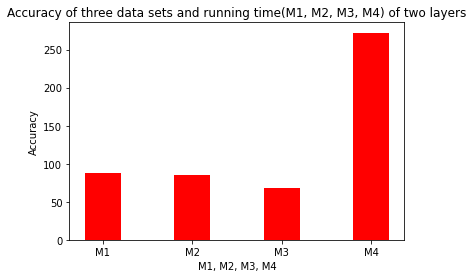

In [35]:
import warnings
warnings.filterwarnings("ignore", category=Warning)
X=['M1', 'M2', 'M3', 'M4']
Y=[two_layers_M1_1, two_layers_M2_1, two_layers_M3_1, two_layers_M4_1]  
fig = plt.figure()
plt.bar(X,Y,0.4,color="red")
plt.xlabel("M1, M2, M3, M4")
plt.ylabel("Accuracy")
plt.title("Accuracy of three data sets and running time(M1, M2, M3, M4) of two layers")
plt.show()

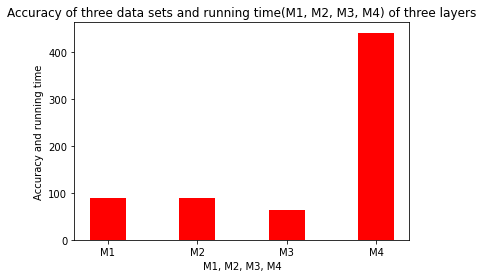

In [36]:
X=['M1', 'M2', 'M3', 'M4']
Y=[three_layers_M1_1, three_layers_M2_1, three_layers_M3_1, three_layers_M4_1]  
fig = plt.figure()
plt.bar(X,Y,0.4,color="red")
plt.xlabel("M1, M2, M3, M4")
plt.ylabel("Accuracy and running time")
plt.title("Accuracy of three data sets and running time(M1, M2, M3, M4) of three layers")
plt.show()

b) Describe at least two observations interesting to you.

1) At the begining, I think the more of epochs, the better because this model could be trained perfectly. But in reality, after adjust my parametres I found that if the number of epoch express 2, the accuracy of test data set will fluctuate, so finally, I chose the number of epochs as 3.<br>
2) When I read the original author's code, I found that thre was a nn.BatchNorm2d() which has powerful ability to increase the accuracy. After I add this parametre in my cnn, the accuracy improved about 4% to 5%.

# D. Unsupervised learning on Fashion-MNIST 

Choose any two out of the 10 classes and use only the test data for these two chosen classes to complete tasks in this section. It will be better to finish reading the remaining part of this section before choosing the two classes. Again, you may choose any two and there is no “correct” answer about which two to choose but some choices may make your studies below more interesting than others.<br>
Use the PyTorch API for Fashion-MNIST to load the test data of Fashion-MNIST.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [38]:
# load data set
batchSize=4
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=2)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print('Test set size:',len(testset))

Test set size: 10000


D1. Dimensionality reduction and clustering

a)Apply PCA to all images of these two chosen classes. Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first).

129.9271
47.86457
12.744058
30.556152
22.93035


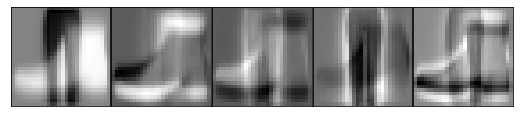

In [39]:
#choose two classes
testset_new = list()
class1 = list()
class9 = list()
index = 0
for i in range(len(testset)):
    if(testset[i][1] == 1):
        class1.append(testset[i])
    elif(testset[i][1] == 9):
        class9.append(testset[i])
testset_new = class1 + class9

#get the top 5 eigenvectors
X = np.array(testset_new[:][0][0]).reshape(1, 28*28)
for i in range(1, len(testset_new[:])):
    X = np.append(X,np.array(testset_new[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
pca = PCA(n_components=0.95)
pca.fit(X)
cov_matrix = np.dot(X.T, X) / len(X)
eigenvector = pca.components_[:5]

#visualize the eigenvectors as images
fig, axes = plt.subplots(1,5,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenvector[i].reshape(28,28),cmap="gray")
    
#display the top 5 eigenvectors in the order of descending corresponding values
for eigenvector in pca.components_[:5]:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

b)Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class). Show these 10 pairs of reconstructed and original images. 

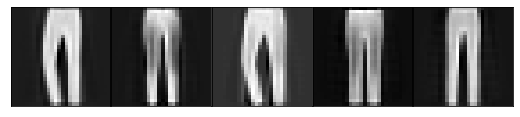

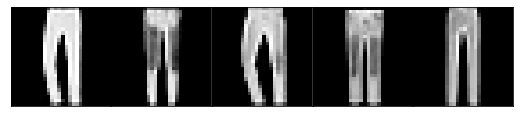

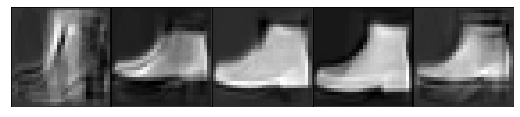

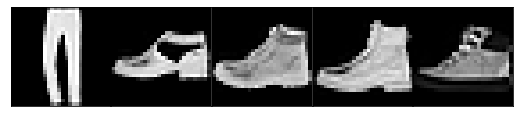

In [40]:
#b)train pcs seperately
#the top30 PCs of new testset which include 2 classes
X = np.array(testset_new[:][0][0]).reshape(1, 28*28)
for i in range(1, len(class1[:])):
    X = np.append(X,np.array(class1[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
pca = PCA(n_components=30)
pca.fit(X)
components = pca.transform(X)
projected = pca.inverse_transform(components)
fig, axes = plt.subplots(1,5,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(28,28),cmap="gray")
    
#show the original images
fig, axes = plt.subplots(1,5,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28,28),cmap="gray")

#the top30 PCs of new testset which include 2 classes
X = np.array(testset_new[:][0][0]).reshape(1, 28*28)
for i in range(1, len(class9[:])):
    X = np.append(X,np.array(class9[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
# X = StandardScaler().fit_transform(X)
pca = PCA(n_components=30)
pca.fit(X)
components = pca.transform(X)
projected = pca.inverse_transform(components)
fig, axes = plt.subplots(1,5,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(28,28),cmap="gray")
    
#show the original images
fig, axes = plt.subplots(1,5,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28,28),cmap="gray")

c)Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using the top two PCs). Use different colours/markers for the two classes for better visualisation

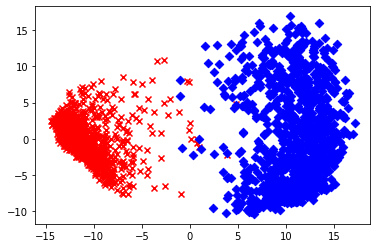

In [41]:
# reduce dimensionality
X = np.array(testset_new[:][0][0]).reshape(1, 28*28)
for i in range(1, len(testset_new[:])):
    X = np.append(X,np.array(testset_new[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
pca = PCA(n_components = 2)
reduced_x = pca.fit_transform(X)

# Save the data after dimensionality reduction by category
red_x,red_y = [],[]
blue_x,blue_y = [],[]
green_x,green_y = [],[]
for i in range(len(reduced_x)):
    if testset_new[:][i][1] == 1:
        red_x.append(reduced_x[i][0])
        red_y.append(reduced_x[i][1])
    elif testset_new[:][i][1] == 9:
        blue_x.append(reduced_x[i][0])
        blue_y.append(reduced_x[i][1])
        
# Data visualization after dimensionality reduction
plt.scatter(red_x,red_y, c = 'r',marker = 'x')
plt.scatter(blue_x,blue_y, c = 'b',marker = 'D')
plt.show()

d) Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D.

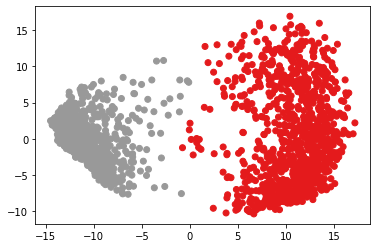

In [42]:
from sklearn.cluster import SpectralClustering
X = np.array(testset_new[:][0][0]).reshape(1, 28*28)
for i in range(1, len(testset_new[:])):
    X = np.append(X,np.array(testset_new[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
clustering = SpectralClustering(n_clusters=2,
        assign_labels="kmeans",
        random_state=0).fit(X_reduced)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clustering.labels_, cmap=plt.cm.Set1)

e) Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You are free to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch.

In [43]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 4 output channel, 2x2 square convolution
            nn.Conv2d(1, 4, 2, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, 2, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 2, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 2, stride=2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=1, padding=0, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 2, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 2, stride=1, padding=0, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 2, stride=2, padding=1, output_padding=0),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
myAE=Autoencoder()
params = list(myAE.parameters())

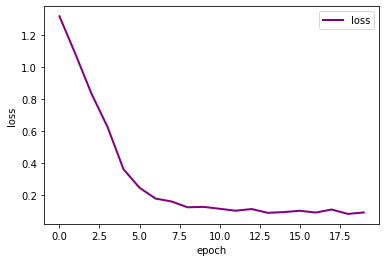

In [44]:
#Training (optimisation) parameters
batch_size=64
learning_rate=1e-3
max_epochs = 20

#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)
#Specify how the data will be loaded in batches (with random shuffling)
test_loader = torch.utils.data.DataLoader(testset_new, batch_size=batch_size, shuffle=True)
#Storage
outputs = []
y_label = [None]*21
#Start training
Loss_list = []
for epoch in range(max_epochs):
    for data in test_loader:
        img, label = data
        optimizer.zero_grad()
        recon = myAE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            
    if (epoch % 1) == 0:
        y_label[epoch]=float(loss)
    outputs.append((epoch, img, recon),)

x = range(21)
plt.plot(x, y_label, ls='-', lw=2, label='loss', color='purple')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

D2 Observation

Describe at least two observations interesting to you from D1 above.

1) At the begining, I chose class 7 and class 9 which are sneaker and boot class as chosen classes. I didnot find anything strange when I answer questions a and b, but when I do question c which is visualising the two-dimensional PCA representations of all data points in a 2D plane, I find that most of one set of data points are coverd by another set of data points. So, I think the reason why it shows this phenomenon is that all of them are shoes, which makes the data points really close to each other. Finally, I changed a different data class and that problem was resolved.<br>
2) Even though the pictures in question d and e are quite similar, there are still some problems in spectral clustering, for example: not all of data points could be classified correctly. This is because of that no matter how close our model is to the real data. It is only applicable to general data. It is quite normal that it cannot correctly classify some extreme data, but what we need to do is to constantly optimize the model so that it gradually approaches the real classification.